# Max-Cut QAOA

Here we have implemented the QAOA algorithm for $n$ layers and $m$ edges.

The number of layers, qubits (nodes) and shots can be set under the 'Constants' section.

We have ANALYTICAL set to True by default, which sets shots to None.

Set ANALYTICAL to False to run the code empirically.

All optimised circuits are compiled to OpenQASM2.0 which we then ran on one of IBM's QPUs.

## Prelims

##### Imports

In [978]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

##### Constants

In [979]:
NUM_QUBITS = 2
LAYERS = 1
ANALYTICAL = True
NUM_SHOTS = 100

##### Predefined Functions

In [980]:

# Draws a given quantum circuit
def draw_circuit(circuit, params=None, **kwargs):
    qml.draw_mpl(circuit, **kwargs)(params)
    plt.tight_layout()

# Draws a graph with given edges
def draw_graph(edges):
    G = nx.Graph()
    G.add_edges_from(edges)
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', width=3, node_size=10000/np.sqrt(len(edges)), font_size=16, font_color='black', edge_color='black')
    plt.xlim([-1.3, 1.3])
    plt.ylim([-1.3, 1.3])

# Gets first n binary bitstrings
def get_bitstrings(n):
    length = len(bin(n-1)) - 2
    binary_numbers = [' ' + bin(i)[2:].zfill(length) + ' ' for i in range(n)]
    return binary_numbers

# Saves a circuit to qasm
def save_circuit(circuit, filename):
    qasm = circuit.qtape.to_openqasm()
    with open(filename, "w") as file:
        file.write(qasm)

## Define the Problem

##### The Graph

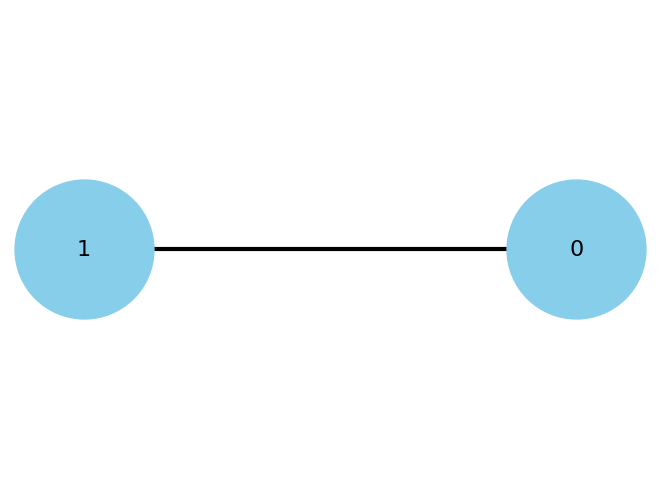

In [981]:
if NUM_QUBITS == 4:
    G = [(0, 1), (1, 2), (2, 3), (3, 0), (3, 1)]
elif NUM_QUBITS == 8:
    G = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 0), (7, 2), (3, 5), (1, 4)]
else:
    G = [(0, 1)]
    NUM_QUBITS = 2
    LAYERS = 1

draw_graph(G)
plt.savefig(f'figures/{NUM_QUBITS}NodeGraph.png', dpi=300)

##### The Hamiltonian and Unitaries

In [982]:
# Cost Hamiltonian
def Hc(graph):
    H = 0
    for u, v in graph:
        H += 0.5 * (1 - qml.PauliZ(u) @ qml.PauliZ(v))
    return H

# Cost Unitary
def Uc(gamma, graph):
    for u, v in graph:
        qml.CNOT(wires=[u, v])
        qml.RZ(-2 * gamma, wires=v)
        qml.CNOT(wires=[u, v])

# Mixer Unitary
def Um(beta, n_qubits):
    for i in range(n_qubits):
        qml.RX(2 * beta, wires=i)

##### The QAOA Ansatz

In [983]:
# Performs n layers of QAOA
def QAOA(gammas, betas, n_layers, n_qubits, graph):
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        
    for i in range(n_layers):
        Uc(gammas[i], graph)
        
        Um(betas[i], n_qubits)

## Define the Circuit

##### Configure the Device

In [984]:
dev = qml.device("default.qubit", wires=NUM_QUBITS, shots = None if ANALYTICAL else NUM_SHOTS)

##### Construct the Circuit

In [985]:
# For optimising the circuit
@qml.qnode(dev)
def circuit(params, n_layers = LAYERS, n_qubits = NUM_QUBITS, graph = G):
    gammas = params[0]
    betas = params[1]
    
    QAOA(gammas, betas, n_layers, n_qubits, graph)
    
    return qml.expval(Hc(graph))

# For geting the final circuit state
@qml.qnode(dev)
def final_state(params, n_layers = LAYERS, n_qubits = NUM_QUBITS, graph = G):
    gammas = params[0]
    betas = params[1]
    
    QAOA(gammas, betas, n_layers, n_qubits, graph)
    
    return qml.probs(wires=list(range(n_qubits)))

##### Circuit Diagram

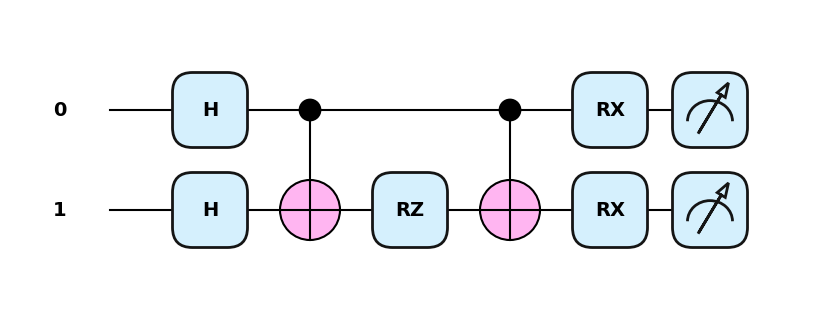

In [986]:
draw_circuit(circuit, np.random.rand(2, LAYERS), style='pennylane')
plt.savefig(f'figures/{NUM_QUBITS}Node_{LAYERS}Layer_Circuit.png', dpi=300)

## Optimising the Parameters

##### Optimisation Procedure

In [987]:
# The full QAOA VQC
def QAOA_maxcut(cost, n_layers = 1, steps = 100):
    
    # Optimiser and initial parameters
    params = 0.1 * np.random.rand(2, n_layers, requires_grad=True)
    optimiser = qml.AdamOptimizer(stepsize=0.1)
    
    loss = []

    # Iteratively Optimise
    for _ in range(steps):
        params = optimiser.step(lambda x: -cost(x), params)
        loss.append(cost(params))
    
    return loss, params

##### Optimised Parameters

In [988]:
loss, params = QAOA_maxcut(circuit, n_layers=LAYERS)

print(f'Gamma = {params[0]}\nBeta = {params[1]}')

Gamma = [0.7860819]
Beta = [0.39364588]


##### Cost Curve

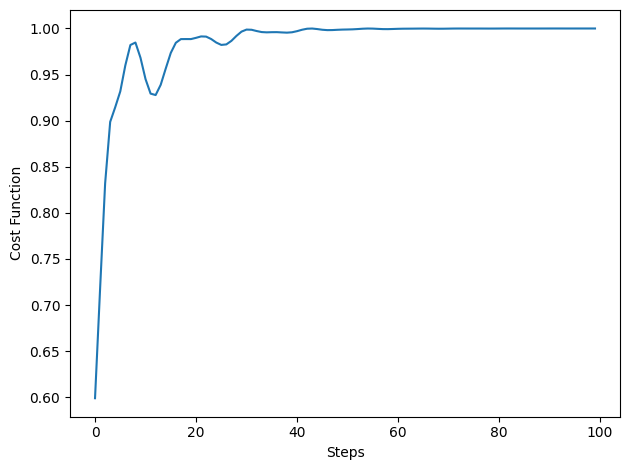

In [989]:
plt.plot(loss)
plt.ylabel('Cost Function')
plt.xlabel('Steps')
plt.tight_layout()
plt.savefig(f'figures/{NUM_QUBITS}Node_{LAYERS}Layer_CostCurve{"Empirical" if not ANALYTICAL else ""}.png', dpi=300)

## Measure the Circuit Outputs

#### The Mode Measurement (Optimal Solution)

In [990]:
observations = final_state(params)
print(np.argmax(observations))

1


##### Measurement Probabilities

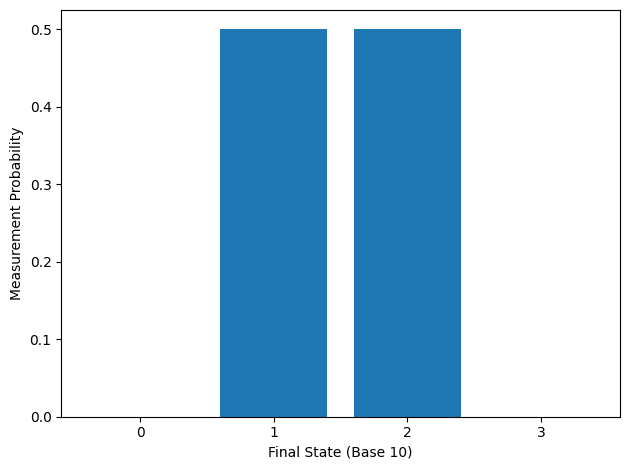

In [991]:
plt.bar([str(i) for i in range(2**NUM_QUBITS)], observations)
plt.tight_layout()
plt.xlabel('Final State (Base 10)')
plt.ylabel('Measurement Probability')
if NUM_QUBITS == 8: plt.xticks(list(range(0, 256, 16)))
plt.tight_layout()
plt.savefig(f'figures/{NUM_QUBITS}Node_{LAYERS}Layer_Probabilities{"Empirical" if not ANALYTICAL else ""}.png', dpi=300)

## Save Circuit for IBM

In [992]:
save_circuit(final_state, f'QASM Circuits/MaxCutQAOA_{NUM_QUBITS}Nodes_{LAYERS}Layers.qasm')